Iteration 1: norm_delta = 0.67204, step_size = 0.9500, log_lik = -1663.17959, newton_decrement = 48.34818, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.04737, step_size = 0.9500, log_lik = -1618.27410, newton_decrement = 0.36324, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00237, step_size = 0.9500, log_lik = -1617.91282, newton_decrement = 0.00087, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1617.91195, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 4 iterations.
                            coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                               
AGE                     0.063465   1.065522  0.079890       -0.093116   
AGEG                   -0.075970   0.926844  0.075970       -0.224868   
SEX                     0.040039   1.040851  0.107873       -0.171387   
CompositeStage          0.526691   1.693319  0.062948        0.403

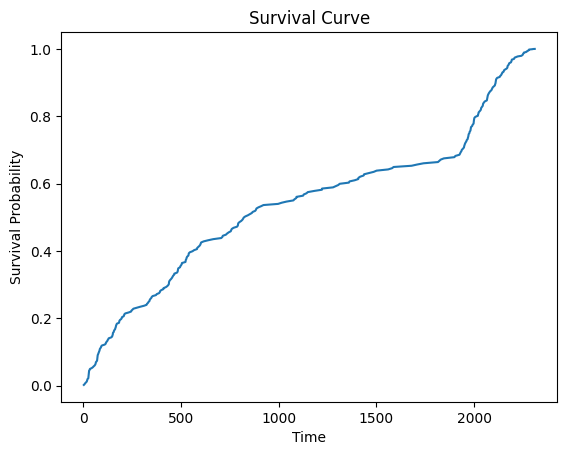

In [52]:
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_excel('data.xlsx') # Load the data from the .xlsx file

# Preprocess the data Drop any rows with missing values in the columns of interest
data = data.dropna(subset=['tstart', 'tstop', 'DEATH', 'AGE', 'AGEG', 'SEX', 'CompositeStage', 'LNInvolment', 'PNI', 'LVE', 'T4', 'Obstruction', 'Perforation', 'Comorbidity', 'FamiliyHistoryOfCancer'])
# Handle missing values in other columns
imputer = SimpleImputer(strategy='median')
data[['DEATH', 'AGE', 'AGEG', 'CompositeStage', 'LNInvolment', 'PNI', 'LVE', 'T4', 'Obstruction', 'Perforation', 'Comorbidity']] = imputer.fit_transform(data[['DEATH', 'AGE', 'AGEG', 'CompositeStage', 'LNInvolment', 'PNI', 'LVE', 'T4', 'Obstruction', 'Perforation', 'Comorbidity']])
# Standardize the covariates
scaler = StandardScaler()
data[['DEATH', 'AGE', 'AGEG', 'CompositeStage', 'LNInvolment', 'PNI', 'LVE', 'T4', 'Obstruction', 'Perforation', 'Comorbidity']] = scaler.fit_transform(data[['DEATH', 'AGE', 'AGEG', 'CompositeStage', 'LNInvolment', 'PNI', 'LVE', 'T4', 'Obstruction', 'Perforation', 'Comorbidity']])
# Create a new DataFrame with the required columns for the Buckley-James estimator
buckley_james_data = data[['tstart', 'tstop', 'DEATH', 'AGE', 'AGEG', 'SEX', 'CompositeStage', 'LNInvolment', 'PNI', 'LVE', 'T4', 'Obstruction', 'Perforation', 'Comorbidity', 'FamiliyHistoryOfCancer']]
#print(buckley_james_data.isnull().sum()) #find no of Nan
# Fit the Buckley-James model with custom options
buckley_james_data = buckley_james_data.drop(['tstart'], axis=1)
#buckley_james_data = buckley_james_data.drop('tstart', axis=1)
cph = CoxPHFitter(penalizer=0.1)  # Set the penalizer parameter to control overfitting
cph.fit(buckley_james_data, 'tstop', 'DEATH', show_progress=True)  # Set the step_size parameter to control the convergence speed
# Print the estimated coefficients
print(cph.summary)
# Access other properties of the fitted model (e.g., hazard ratios, p-values)
# For example, to get the hazard ratios:
print(cph.hazard_ratios_)
# Make predictions using the fitted model
# For example, to predict the survival probability at a specific time point for a new patient:
new_patient_data = pd.DataFrame({'AGE': [50], 'AGEG': [1], 'SEX': [1], 'CompositeStage': [2], 'LNInvolment': [1], 'PNI': [0], 'LVE': [0], 'T4': [0], 'Obstruction': [0], 'Perforation': [0], 'Comorbidity': [0], 'FamiliyHistoryOfCancer': [0]})
partial_hazard = cph.predict_partial_hazard(new_patient_data)
survival_prob = 1 - cph.baseline_survival_
plt.plot(cph.baseline_survival_.index, survival_prob.values)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curve')
plt.show()
# Perform other analyses or visualizations as needed